In [217]:
import nltk
import gensim
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from data_reader import read_data
from data_preprocessing import preprocess_data

import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
data = read_data()
# Uncomment for word normalization
# data = preprocess_data(data, normalize_text=True, save_file='data_with_orgs_norm.tsv')
# data = read_data(file_path='data_with_orgs_norm.tsv')
data = preprocess_data(data)
data.head()

,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,StatusDisplayName,StatusCode,SuppliersCount,IsWinner,Inn,Kpp,Name,Ogrn,ResultClass,Ogrn1
0,0100600000117000001,"Закупки товаров, работ, услуг в соответствии с...",https://zakupki.kontur.ru/0100600000117000001,2017-04-13,Закупка у единственного поставщика (подрядчика...,1310000.0,1310000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47
1,0100600000117000002,"Закупки товаров, работ, услуг в соответствии с...",https://zakupki.kontur.ru/0100600000117000002,2017-04-13,Закупка у единственного поставщика (подрядчика...,249000.0,249000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47
2,0100600000117000003,"Закупки товаров, работ, услуг в соответствии с...",https://zakupki.kontur.ru/0100600000117000003,2017-07-06,Закупка у единственного поставщика (подрядчика...,250000.0,250000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47
3,0100600000117000004,Выполнение работ по ремонту автомобильной доро...,https://zakupki.kontur.ru/0100600000117000004,2017-07-06,Запрос котировок,400300.0,400300.0,RUB,Размещение завершено,2.0,2.0,1.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,1.0,47
4,0100600000117000005,Приобретение и установка спортивного оборудования,https://zakupki.kontur.ru/0100600000117000005,2017-07-10,Запрос котировок,451000.0,451000.0,RUB,Размещение завершено,2.0,1.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47


In [219]:
data.groupby('SuppliersCount').size()

SuppliersCount
0.0     50976
1.0     53973
2.0     61407
3.0     36579
4.0     24126
5.0     14110
6.0      6518
7.0      3402
8.0      1746
9.0      1101
10.0      448
11.0      148
12.0       73
13.0       58
14.0       75
15.0       12
16.0       27
17.0        3
18.0        4
19.0        2
20.0        1
dtype: int64

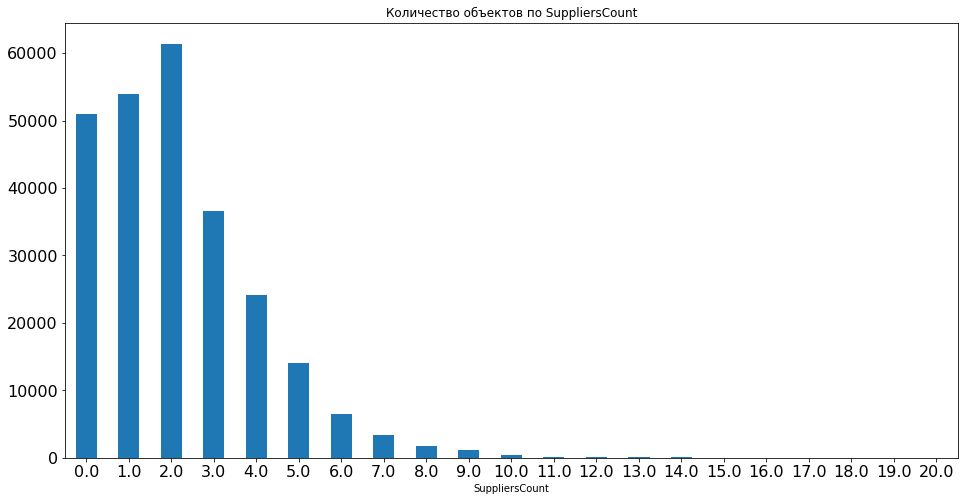

In [220]:
data.groupby('SuppliersCount').size().plot(kind='bar', figsize=(16, 8), title='Количество объектов по SuppliersCount', fontsize=16, rot=0)

In [221]:
g = data.groupby('SuppliersCount')
data = g.apply(lambda x: x.head(5000)).sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,StatusDisplayName,StatusCode,SuppliersCount,IsWinner,Inn,Kpp,Name,Ogrn,ResultClass,Ogrn1
0,0101200009716000032,Оказание услуг по обслуживанию пассажиров в ВИ...,https://zakupki.kontur.ru/0101200009716000032,2016-12-12,Запрос котировок,499000.00,499000.00,RUB,Размещение завершено,2.0,1.0,0.0,0274151354,NaN,УПРАВЛЕНИЕ ДЕЛАМИ ГЛАВЫ РЕСПУБЛИКИ БАШКОРТОСТАН,1100280037813,0.0,2
1,0111300063217000348,Поставка сухофруктов для пришкольных лагерей,https://zakupki.kontur.ru/0111300063217000348,2017-05-19,Электронный аукцион,89080.00,89080.00,RUB,Размещение завершено,2.0,7.0,1.0,1644068560,NaN,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ОБЩЕОБРАЗОВАТЕЛЬНОЕ УЧ...,1131644001818,1.0,16
2,0101200009516005909,Электронный аукцион [g000946245/7386g] на прав...,https://zakupki.kontur.ru/0101200009516005909,2016-12-15,Электронный аукцион,2478906.69,2478906.69,RUB,Размещение завершено,2.0,1.0,0.0,0276006472,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,1030204207440,0.0,2
3,0111200000916000574,"Право заключения государственного контракта, г...",https://zakupki.kontur.ru/0111200000916000574,2016-07-06,Электронный аукцион,1548791.00,1548791.00,RUB,Размещение завершено,2.0,7.0,1.0,1656012756,NaN,ГОСУДАРСТВЕННОЕ АВТОНОМНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,1021603063767,1.0,16
4,0101300006016000004,Текущий ремонт объездной дороги в с. Буруновка...,https://zakupki.kontur.ru/0101300006016000004,2016-06-01,Запрос котировок,499996.00,499996.00,RUB,Размещение завершено,2.0,1.0,0.0,0219001252,NaN,АДМИНИСТРАЦИЯ СЕЛЬСКОГО ПОСЕЛЕНИЯ БУРУНОВСКИЙ ...,1020201253555,0.0,2


In [222]:
data.groupby('SuppliersCount').size()

SuppliersCount
0.0     5000
1.0     5000
2.0     5000
3.0     5000
4.0     5000
5.0     5000
6.0     5000
7.0     3402
8.0     1746
9.0     1101
10.0     448
11.0     148
12.0      73
13.0      58
14.0      75
15.0      12
16.0      27
17.0       3
18.0       4
19.0       2
20.0       1
dtype: int64

In [223]:
text_columns = ["Title", "Name"]
categorical_columns = ["ProcedureDisplayName", "CurrencyCode", "Ogrn1"]
numerical_columns = ['RubPrice']
target_column = "SuppliersCount"

In [224]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

In [225]:
# uncomment for BPE
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE

# split and tokenize the data
# with open('train.txt', 'w', encoding='utf8') as f:
#     for col in text_columns:
#         data[col].map(lambda src_line: f.write(src_line + '\n'))

# build and apply bpe vocs
# learn_bpe(open('./train.txt', encoding='utf8'), open('bpe_rules.txt', 'w', encoding='utf8'), num_symbols=8000)
# bpe = BPE(open('./bpe_rules.txt', encoding='utf8'))

# for col in text_columns:
#     data[col] = data[col].apply(lambda l: bpe.process_line(l.strip()))

# data.head()

In [226]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
for e in data['Title'].append(data['Name']):
    for s in e.split(' '):
        token_counts[s] += 1

In [227]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 23385
('"', 42866)
('республики', 34398)
('по', 24819)
('башкортостан', 24049)
('учреждение', 21802)
...
('дрожжановская', 1)
('акушинский', 1)
('нижнесикиязовский', 1)


In [228]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [el for el in token_counts.keys() if token_counts[el] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [229]:
print("Tokens left:", len(tokens))

Tokens left: 4536


In [230]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [231]:
# uncomment for char based RNN
tokens = list(set(''.join(data['Title'].append(data['Name']))))

tokens = [UNK, PAD] + list(sorted(tokens))
n_tokens = len(tokens)
token_to_id = {tokens[i]:i for i in range(n_tokens)}

n_tokens

102

In [232]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    # uncomment for word based RNN
    # if isinstance(sequences[0], str):
    #     sequences = list(map(str.split, sequences))
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [233]:
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

In [234]:
def oversample(rows):
    if len(rows) < 10:
        return rows.append([rows]*2000, ignore_index=True)
    if len(rows) < 100:
        return rows.append([rows]*200, ignore_index=True)
    if len(rows) < 1000:
        return rows.append([rows]*20, ignore_index=True)
    if len(rows) < 10000:
        return rows.append([rows]*5, ignore_index=True)
    if len(rows) < 20000:
        return rows.append([rows]*2, ignore_index=True)
    if len(rows) < 30000:
        return rows.append([rows]*1, ignore_index=True)
    return rows

def oversample_val(rows):
    if len(rows) < 10:
        return rows.append([rows]*200, ignore_index=True)
    if len(rows) < 100:
        return rows.append([rows]*20, ignore_index=True)
    if len(rows) < 1000:
        return rows.append([rows]*5, ignore_index=True)
    return rows

In [235]:
data_train, data_val = train_test_split(data, test_size=0.3, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  29470
Validation size =  12630


In [236]:
# g = data_train.groupby('SuppliersCount')
# data_train = g.apply(oversample).sample(frac=1).reset_index(drop=True)
# data_train.groupby('SuppliersCount').size()

In [237]:
# g = data_val.groupby('SuppliersCount')
# data_val = g.apply(oversample_val).sample(frac=1).reset_index(drop=True)
# data_val.groupby('SuppliersCount').size()

In [238]:
# Uncomment for pretrained embedding
# embeddings = gensim.models.KeyedVectors.load("C:/Users/feikf/Downloads/Archives/187/model.model")
# indices = {}
# mat = np.zeros((len(tokens), embeddings.vectors.shape[1]))
# for e in embeddings.vocab:
#     if e in token_to_id:
#         mat[token_to_id[e], : ] = embeddings[e]

# print(len(tokens))
# print(mat.shape)

In [239]:
def maybe_cuda(tensor):
    return tensor.cuda()

In [240]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    # cat = [categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))]
    # vals = data[numerical_columns[0]].map(float).values
    # cat.append(vals.reshape(len(vals), 1))
    # batch['Categorical'] = np.concatenate(cat, axis=1)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [241]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, size=None, dim=-1):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

class GlobalAvgPooling(nn.Module):
    def __init__(self, size=None, dim=-1):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.mean(dim=self.dim)

class SoftmaxPooling(nn.Module):
    def __init__(self, size=None, dim=-1):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return torch.sum(x*torch.exp(x), dim=self.dim)/torch.sum(torch.exp(x), dim=self.dim)

class Reshape(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.transpose(x, 1, 2)
    
class AttentivePooling(nn.Module):
    def __init__(self, size=256, dim=-1):
        super().__init__()
        self.dim = dim
        self.attn = nn.Sequential(
            nn.Linear(size, size),
            # Reshape(),
            # nn.BatchNorm1d(size),
            # Reshape(),
            nn.ReLU(),
            nn.Linear(size, size)
        )
    
    def forward(self, x):
        attn = self.attn(x)
        return torch.sum(x*torch.exp(attn), dim=self.dim)/torch.sum(torch.exp(attn), dim=self.dim)

In [242]:
class GruEncoder(nn.Module):
    def __init__(self, pooling=GlobalMaxPooling, emb_w=None, n_tokens=len(tokens), emb_size=64, out_size=64):
        super().__init__()
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        if emb_w is not None:
            self.emb.weight.data.copy_(torch.from_numpy(emb_w))
            
        self.enc0 = nn.GRU(emb_size, out_size, batch_first=True)
        self.enc1 = nn.Sequential(
            nn.ReLU(),
            pooling(size=out_size, dim=1),
            nn.Linear(out_size, out_size)
        )
        
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        h, _ = self.enc0(h)
        return self.enc1(h)

class LstmEncoder(nn.Module):
    def __init__(self, pooling=GlobalMaxPooling, emb_w=None, n_tokens=len(tokens), emb_size=64, out_size=64):
        super().__init__()
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        if emb_w is not None:
            self.emb.weight.data.copy_(torch.from_numpy(emb_w))
            
        self.enc0 = nn.LSTM(emb_size, out_size, batch_first=True)
        self.enc1 = nn.Sequential(
            nn.ReLU(),
            pooling(size=out_size, dim=1),
            nn.Linear(out_size, out_size)
        )
        
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        h, _ = self.enc0(h)
        return self.enc1(h)
    
class ConvEncoder(nn.Module):
    def __init__(self, pooling=GlobalMaxPooling, emb_w=None, n_tokens=len(tokens), emb_size=64, out_size=64):
        super().__init__()
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        if emb_w is not None:
            self.emb.weight.data.copy_(torch.from_numpy(emb_w))
        
        self.enc = nn.Sequential(
            nn.Conv1d(emb_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_size),
            nn.ReLU(),
            nn.Conv1d(out_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_size),
            nn.ReLU(),
            nn.Conv1d(out_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_size),
            nn.ReLU(),
            pooling(),
            nn.Linear(out_size, out_size)
        )
        
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        return self.enc(h)

In [243]:
class FullNetwork(nn.Module):
    def __init__(self, pooling=GlobalMaxPooling, text_enc=GruEncoder, emb_w=None, emb_size=64, out_size=64,
                 n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_),
                 n_num_features=len(numerical_columns)):
        super().__init__()
        
        self.title_enc = text_enc(pooling=pooling, emb_w=emb_w, emb_size=emb_size, out_size=out_size)
        self.name_enc = text_enc(pooling=pooling, emb_w=emb_w, emb_size=emb_size, out_size=out_size)
        
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, out_size)
        )

        self.res_layer = nn.Sequential(
            nn.Linear(out_size*3, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )        
    
    def forward(self, title_ix, name_ix, cat_features):
        title_h = self.title_enc(title_ix)
        name_h = self.name_enc(name_ix)
        cat_h = self.cat_enc(cat_features)
        
        joint_h = torch.cat([title_h, name_h, cat_h], dim=1)
        result = self.res_layer(joint_h)
        
        return result[:, 0]

In [244]:
def compute_loss(reference, prediction):
    return torch.mean((prediction - reference) ** 2)

def compute_loss_np(reference, prediction):
    return np.mean((prediction - reference)**2)

def compute_mae(reference, prediction):
    return np.abs(reference - prediction).mean()

def compute_r2(reference, prediction):
    y_mean = np.mean(reference)
    sq_err = np.sum((prediction - reference)**2)
    return 1 - sq_err/np.sum((reference - y_mean)**2)

def compute_r2_loss(reference, prediction):
    y_mean = torch.mean(reference)
    sq_err = torch.sum((prediction - reference)**2)
    return -(1 - sq_err/torch.sum((reference - y_mean)**2))

In [245]:
def after_each_epoch_fn(*args, **kwargs):
    epoch_i = kwargs['epoch_i']
    n_epoch = kwargs['n_epoch']
    start = kwargs['epoch_start']
    end = kwargs['epoch_end']
    mae = kwargs['epoch_mae']
    r2 = kwargs['epoch_r2']
    print(f'\rEpoch #{epoch_i + 1}/{n_epoch} epoch_mae: {mae:.4f}, r2: {r2:.4f}, epoch_time: {end - start:.2f} s', end='')

def after_each_batch_fn(*args, **kwargs):
    return
    epoch_i = kwargs['epoch_i']
    n_epoch = kwargs['n_epoch']
    print(f'\rEpoch #{epoch_i + 1}/{n_epoch} ({get_batch_string(*args, **kwargs)})', end='')

def get_batch_string(*args, **kwargs):
    batch_i = kwargs['batch_i']
    n_batch = kwargs['n_batch']
    start = kwargs['batch_start']
    end = kwargs['batch_end']
    loss = kwargs['batch_loss']
    return f'batch #{batch_i + 1}/{n_batch}, batch_loss: {loss:.5f}, batch_time: {end - start:.3f} s'

In [246]:
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    for start in range(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [247]:
import time

def train(name, model, opt, num_epochs=100, max_len=100, batch_size=32, batches_per_epoch=100, save_best=True, early_stop_after=10):
    val_mae_means = []
    val_r2 = []
    callback_params = {'n_epoch': num_epochs, 'n_batch': batches_per_epoch}
    for epoch_i in range(num_epochs):
        callback_params['epoch_i'] = epoch_i
        callback_params['epoch_start'] = time.time()

        train_loss = []
        model.train(True)

        for batch_i, batch in enumerate(iterate_minibatches(data_train, max_batches=batches_per_epoch)):
            callback_params['batch_i'] = batch_i
            callback_params['batch_start'] = time.time()

            title_ix = Variable(maybe_cuda(torch.LongTensor(batch["Title"])))
            name_ix = Variable(maybe_cuda(torch.LongTensor(batch["Name"])))
            cat_features = Variable(maybe_cuda(torch.FloatTensor(batch["Categorical"])))
            reference = Variable(maybe_cuda(torch.FloatTensor(batch[target_column])))

            prediction = model(title_ix, name_ix, cat_features)

            loss = compute_r2_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss.append(loss.data.cpu().numpy())

            callback_params['batch_end'] = time.time()
            callback_params['batch_loss'] = train_loss[-1]

            after_each_batch_fn(**callback_params)

        model.train(False)

        refs = []
        preds = []
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(maybe_cuda(torch.LongTensor(batch["Title"])))
            desc_ix = Variable(maybe_cuda(torch.LongTensor(batch["Name"])))
            cat_features = Variable(maybe_cuda(torch.FloatTensor(batch["Categorical"])))
            prediction = model(title_ix, desc_ix, cat_features)

            preds.extend(prediction.data.cpu().numpy())
            refs.extend(batch[target_column])

        refs = np.array(refs)
        preds = np.array(preds)
        
        cur_mae = compute_mae(refs, preds)
        cur_r2 = compute_r2(refs, preds)
        if np.isnan(cur_r2):
            print(f'\nEncountered nan in epoch #{epoch_i + 1}', end='')
            break
        
        val_mae_means.append(cur_mae)
        val_r2.append(cur_r2)

        local_max = np.max(val_r2)

        if save_best and val_r2[-1] == local_max:
            torch.save(model.state_dict(), name)

        callback_params['epoch_end'] = time.time()
        callback_params['epoch_mae'] = val_mae_means[-1]
        callback_params['epoch_r2'] = val_r2[-1]

        after_each_epoch_fn(**callback_params)

        if len(val_r2) > early_stop_after and local_max not in val_r2[-early_stop_after:]:
            print(f'\nEarly stopped after epoch #{epoch_i + 1}', end='')
            break

    print(
        f'\nBest validation R2: {np.max(val_r2):.4f}, best validation MAE: {np.min(val_mae_means):.4f}' +
        (f', best model saved to "{name}"' if save_best else '')
    )

    f = plt.figure(figsize=(12, 4))
    
    ax1 = f.add_subplot(121)
    ax1.set_title(name)
    ax1.set_xlabel('n_epoch')
    ax1.set_ylabel('R2')
    ax1.plot(list(range(1, len(val_r2) + 1)), val_r2)
    
    ax2 = f.add_subplot(122)
    ax2.set_title(name)
    ax2.set_xlabel('n_epoch')
    ax2.set_ylabel('MAE')
    ax2.plot(list(range(1, len(val_mae_means) + 1)), val_mae_means)

    plt.show()

In [248]:
def evaluate(model):
    print("Final eval:")
    
    refs = []
    preds = []
    for batch in iterate_minibatches(data_val):
        title_ix = Variable(maybe_cuda(torch.LongTensor(batch["Title"])))
        desc_ix = Variable(maybe_cuda(torch.LongTensor(batch["Name"])))
        cat_features = Variable(maybe_cuda(torch.FloatTensor(batch["Categorical"])))
        prediction = model(title_ix, desc_ix, cat_features)

        preds.extend(prediction.data.cpu().numpy())
        refs.extend(batch[target_column])
    
    refs = np.array(refs)
    preds = np.array(preds)
    
    print("\tLoss:\t%.5f" % compute_loss_np(refs, preds))
    print("\tMAE:\t%.5f" % compute_mae(refs, preds))
    print("\tR2:\t%.5f" % compute_r2(refs, preds))

Epoch #200/200 epoch_mae: 0.8497, r2: 0.7443, epoch_time: 6.34 s
Best validation R2: 0.7514, best validation MAE: 0.8497, best model saved to "baseline"


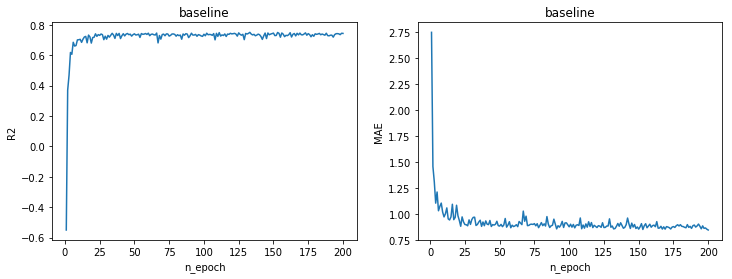

In [72]:
model = maybe_cuda(FullNetwork(emb_size=128, out_size=512))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8570, r2: 0.7433, epoch_time: 5.46 s
Best validation R2: 0.7468, best validation MAE: 0.8437, best model saved to "baseline"


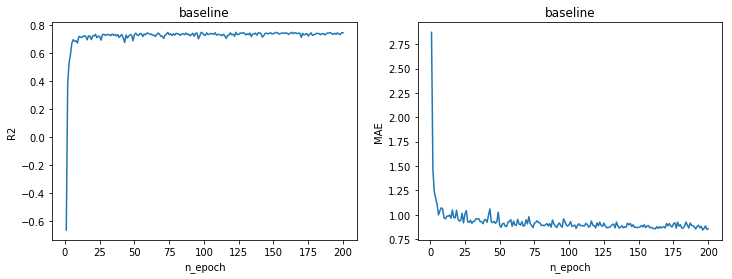

In [73]:
model = maybe_cuda(FullNetwork(emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8774, r2: 0.7290, epoch_time: 6.05 s
Best validation R2: 0.7494, best validation MAE: 0.8602, best model saved to "baseline"


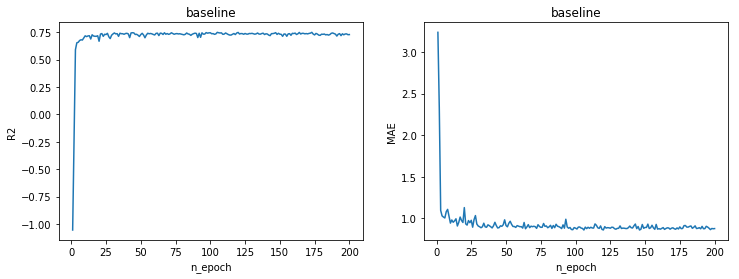

In [74]:
model = maybe_cuda(FullNetwork(emb_size=128, out_size=256))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8752, r2: 0.7327, epoch_time: 5.90 s
Best validation R2: 0.7444, best model saved to "baseline"


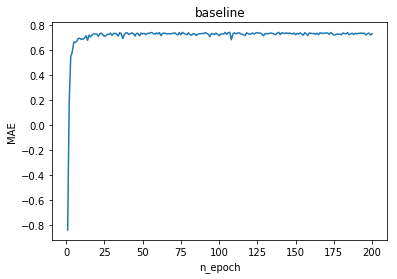

In [ ]:
model = maybe_cuda(FullNetwork(emb_size=128, out_size=128))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.9086, r2: 0.7316, epoch_time: 6.39 s
Best validation R2: 0.7447, best model saved to "baseline"


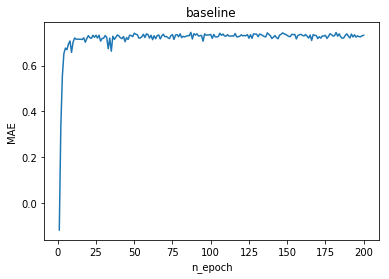

In [ ]:
model = maybe_cuda(FullNetwork(emb_size=128, out_size=64))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

In [ ]:
model = maybe_cuda(FullNetwork(emb_size=64, out_size=64))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #15/200 epoch_mae: 1.0052, r2: 0.7108, epoch_time: 5.90 s

In [ ]:
model = maybe_cuda(FullNetwork(emb_size=32, out_size=32))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

In [160]:
model.load_state_dict(torch.load('baseline'))
evaluate(model)

Final eval:
	Loss:	1.92464
	MAE:	0.89769
	R2:	0.73211


Epoch #200/200 epoch_mae: 0.9056, r2: 0.7377, epoch_time: 5.59 s
Best validation R2: 0.7536, best validation MAE: 0.8417, best model saved to "baseline"


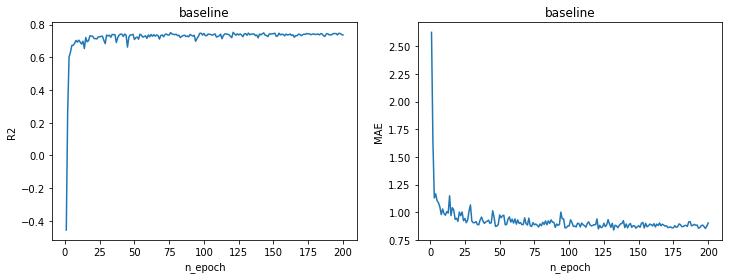

In [59]:
model = maybe_cuda(FullNetwork(emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8891, r2: 0.7316, epoch_time: 5.56 s
Best validation R2: 0.7422, best validation MAE: 0.8552, best model saved to "baseline"


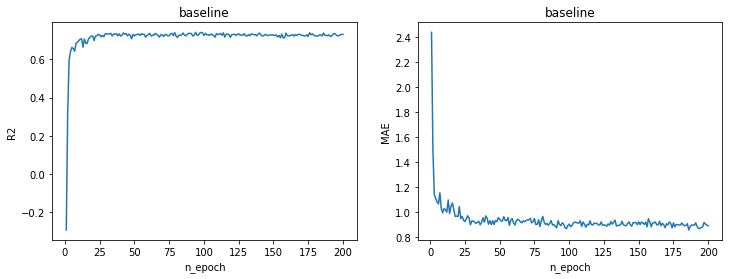

In [60]:
model = maybe_cuda(FullNetwork(pooling=GlobalAvgPooling, emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8727, r2: 0.7379, epoch_time: 5.82 s
Best validation R2: 0.7459, best validation MAE: 0.8566, best model saved to "baseline"


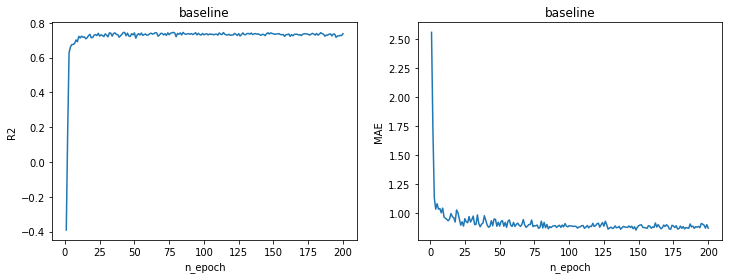

In [61]:
model = maybe_cuda(FullNetwork(pooling=SoftmaxPooling, emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #137/200 epoch_mae: 0.8956, r2: 0.7369, epoch_time: 6.61 s
Encountered nan in epoch #138
Best validation R2: 0.7502, best validation MAE: 0.8595, best model saved to "baseline"


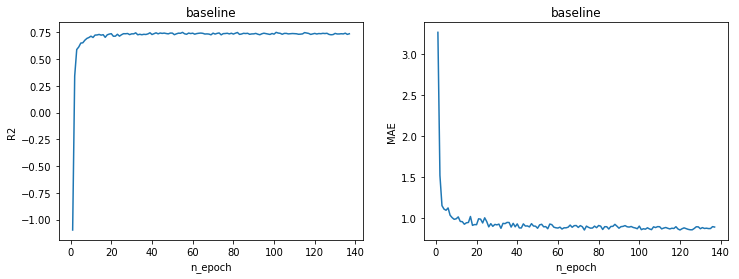

In [75]:
model = maybe_cuda(FullNetwork(pooling=AttentivePooling, emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8522, r2: 0.7415, epoch_time: 5.89 s
Best validation R2: 0.7491, best validation MAE: 0.8446, best model saved to "baseline"


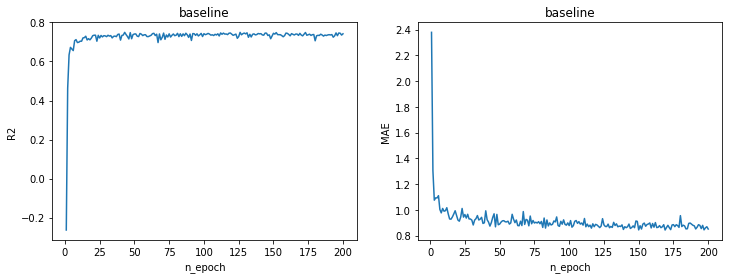

In [63]:
model = maybe_cuda(FullNetwork(text_enc=LstmEncoder, emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8961, r2: 0.7251, epoch_time: 6.13 s
Best validation R2: 0.7405, best validation MAE: 0.8630, best model saved to "baseline"


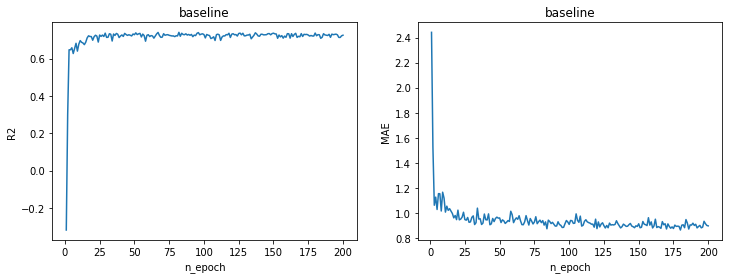

In [64]:
model = maybe_cuda(FullNetwork(text_enc=ConvEncoder, emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8945, r2: 0.7365, epoch_time: 5.77 s
Best validation R2: 0.7490, best validation MAE: 0.8566, best model saved to "baseline"


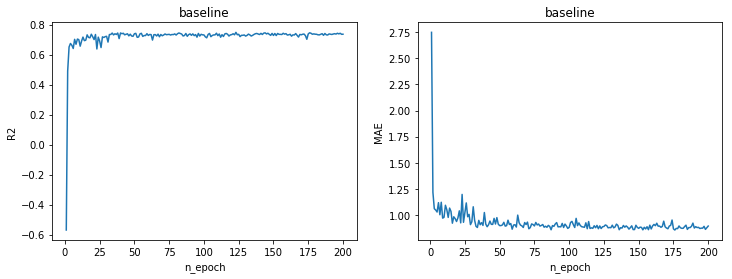

In [66]:
# bidirectional
model = maybe_cuda(FullNetwork(emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8794, r2: 0.7315, epoch_time: 7.72 s
Best validation R2: 0.7421, best validation MAE: 0.8775, best model saved to "baseline"


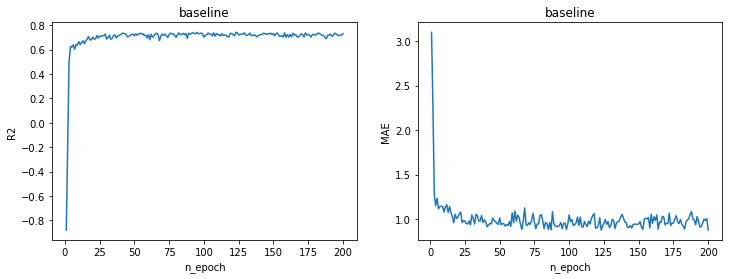

In [69]:
# 3 layer
model = maybe_cuda(FullNetwork(emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8479, r2: 0.7446, epoch_time: 5.28 s
Best validation R2: 0.7507, best validation MAE: 0.8479, best model saved to "baseline"


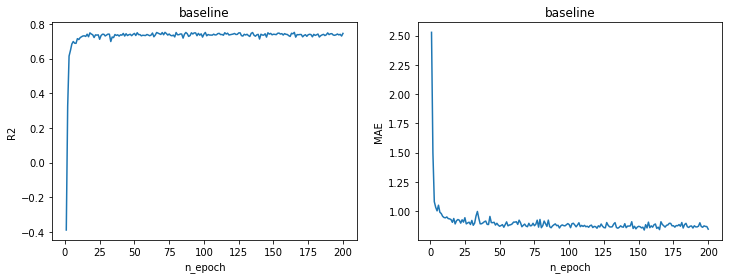

In [175]:
# normalized
model = maybe_cuda(FullNetwork(emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.8752, r2: 0.7448, epoch_time: 5.69 s
Best validation R2: 0.7496, best validation MAE: 0.8470, best model saved to "baseline"


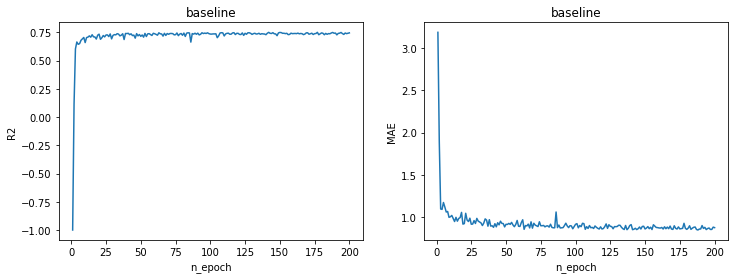

In [216]:
# bpe
model = maybe_cuda(FullNetwork(emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)

Epoch #200/200 epoch_mae: 0.9782, r2: 0.7127, epoch_time: 10.28 s
Best validation R2: 0.7351, best validation MAE: 0.8821, best model saved to "baseline"


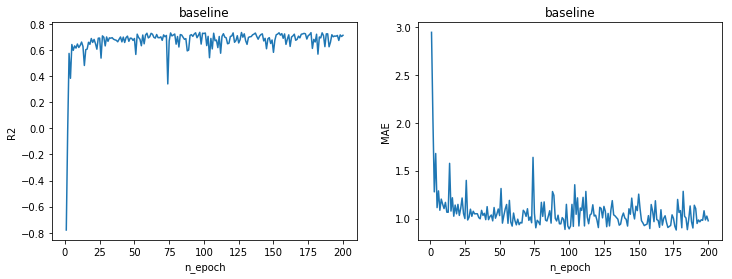

In [249]:
# char rnn
model = maybe_cuda(FullNetwork(emb_size=128, out_size=300))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt, num_epochs=200, early_stop_after=200)